In [232]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split

import umap
from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [233]:
df_train = pd.read_csv('mercedes-benz-greener-manufacturing/train.csv')
df_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [234]:
df_test = pd.read_csv('mercedes-benz-greener-manufacturing/test.csv')
df_test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [235]:
def ordinalEncode(data, test=False):
    oe = preprocessing.OrdinalEncoder()
    
    if test:
        encoder = data.drop(['ID'],axis=1)
    else:
        encoder = data.drop(['y','ID'], axis=1)
        
    encoder1 = encoder.select_dtypes(exclude='int64')
    encoder1 = oe.fit_transform(encoder1)
    encoder2 = encoder.select_dtypes(include='int64')
    encodedvals = np.append(encoder1,encoder2,axis=1)
    encodedframe = pd.DataFrame(encodedvals.astype('int'))
    
    return encodedframe

In [ ]:
def UMAPKNNLabeler(data, test=False):
    reducer = umap.UMAP(n_neighbors=5)
    scaler = StandardScaler()
    scaler.fit(data)
    
    enscaled = scaler.transform(data)
    embedding = reducer.fit_transform(enscaled)
    print(embedding.shape)
    
    e_df = pd.DataFrame(embedding)
    
    if test:
        e_df['y'] = df_te['y']

In [111]:
reducer = umap.UMAP(n_neighbors=5)
scaler = StandardScaler()

scaler.fit(encodedframe)
enscaled = scaler.transform(encodedframe)
embedding = reducer.fit_transform(enscaled)
embedding.shape

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


(4209, 2)

In [112]:
e_df = pd.DataFrame(embedding)

In [195]:
e_df2 = e_df.iloc[:,:-2]
e_df2

,0,1
0,18.294453,3.530245
1,9.594337,-0.008078
2,-7.047596,-9.159743
3,-6.846927,-9.071121
4,-9.641908,-8.633237
...,...,...
4204,15.317159,13.089939
4205,9.737570,13.862495
4206,4.155037,5.425560
4207,3.406889,0.427918


In [113]:
e_df['y'] = df_train['y']

In [ ]:
k = KMeans(n_clusters=2, random_state=42)
kfit = k.fit(e_df.values.reshape(-1, 1))
kpred = kfit.predict(e_df['y'].values.reshape(-1, 1))

In [214]:
k1 = KMeans(n_clusters=40, random_state=42)
kfit1 = k1.fit(e_df2)
kpred1 = kfit1.predict(e_df2)

In [216]:
e_df['klabelsY'] = pd.Series(kpred, index=e_df.index)

Text(0.5, 1.0, 'UMAP projection of the Mercedes-Benz dataset')

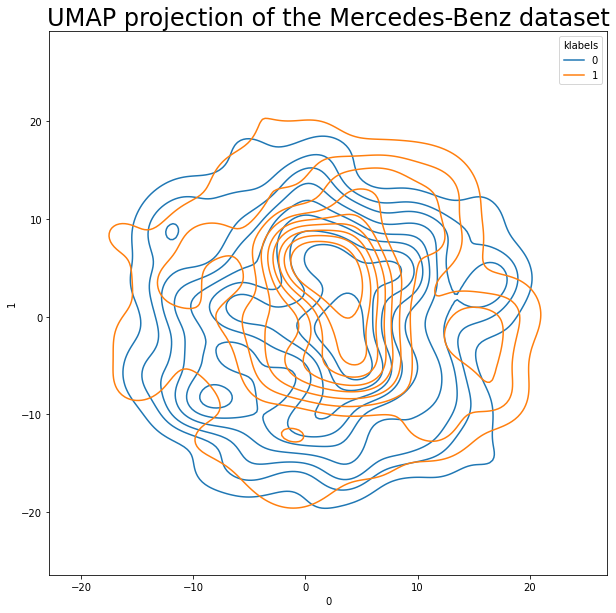

In [117]:
plt.figure(figsize=(10,10))
sns.kdeplot(data=e_df,
    x = e_df.iloc[:, 0],
    y = e_df.iloc[:, 1],
    hue= 'klabelsY', fill=False, palette='tab10')#[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])

plt.title('UMAP projection of the Mercedes-Benz dataset', fontsize=24)

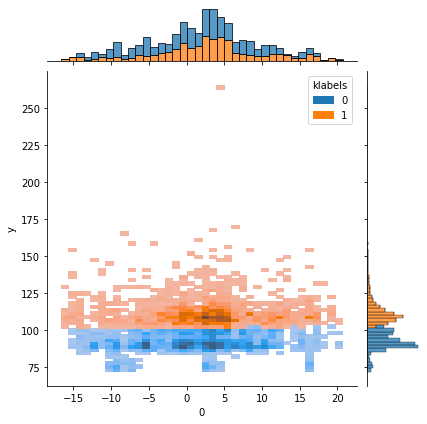

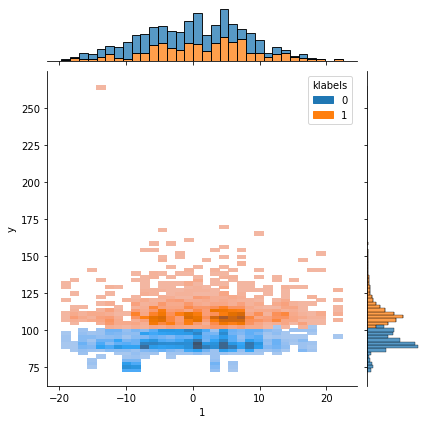

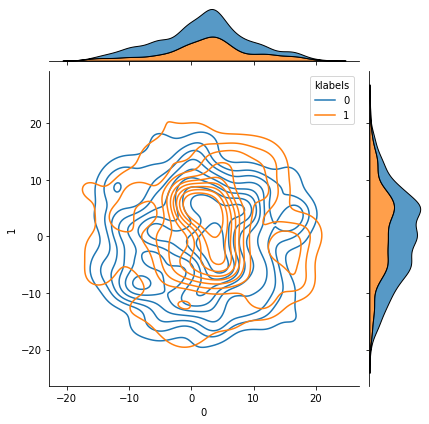

In [219]:
g = sns.jointplot(data=e_df, x=e_df[0], y='y', kind="hist", hue='klabelsY', palette='tab10', marginal_kws={'palette': 'tab10', 'multiple':'stack'})
plt.show()
g = sns.jointplot(data=e_df, x=e_df[1], y='y', kind="hist", hue='klabelsY', palette='tab10', marginal_kws={'palette': 'tab10', 'multiple':'stack'})
plt.show()
g = sns.jointplot(data=e_df, x=e_df[0], y=e_df[1], kind="kde", hue='klabelsY', palette='tab10', marginal_kws={'palette': 'tab10', 'multiple':'stack'})
plt.show()

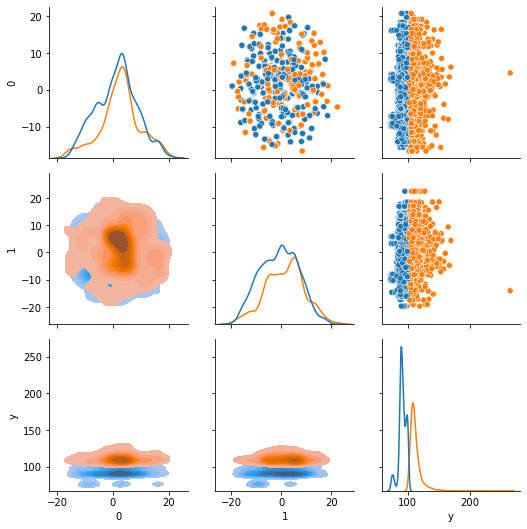

In [119]:
g = sns.PairGrid(e_df, hue='klabelsY', palette='tab10')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, fill=True, alpha=1)

In [46]:
label = []
for x in range(2):
    label.append(e_df.loc[e_df['klabelsY']==x])

<AxesSubplot:ylabel='y'>

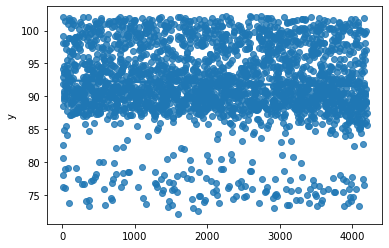

In [50]:
sns.regplot(data=label[0], x=label[0].index, y='y')

<AxesSubplot:ylabel='y'>

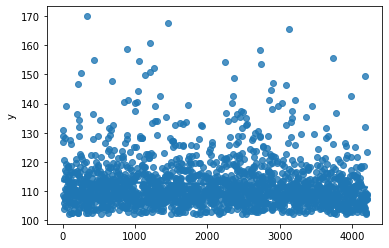

In [51]:
sns.regplot(data=label[1], x=label[1].index, y='y')

In [122]:
encodedframe['klabels'] = e_df['klabelsY']
encodedframe['y'] = e_df['y']
encodedframe

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,klabels,y
0,32,23,17,0,3,24,9,14,0,0,...,1,0,0,0,0,0,0,0,1,130.81
1,32,21,19,4,3,28,11,14,0,0,...,0,0,0,0,0,0,0,0,0,88.53
2,20,24,34,2,3,27,9,23,0,0,...,0,0,0,0,1,0,0,0,0,76.26
3,20,21,34,5,3,27,11,4,0,0,...,0,0,0,0,0,0,0,0,0,80.62
4,20,23,34,5,3,12,3,13,0,0,...,0,0,0,0,0,0,0,0,0,78.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8,20,16,2,3,0,3,16,0,0,...,0,0,0,0,0,0,0,0,1,107.39
4205,31,16,40,3,3,0,7,7,0,0,...,0,0,0,0,0,0,0,0,1,108.77
4206,8,23,38,0,3,0,6,4,0,0,...,1,0,0,0,0,0,0,0,1,109.22
4207,9,19,25,5,3,0,11,20,0,0,...,0,0,0,0,0,0,0,0,0,87.48


In [131]:
scaler = StandardScaler()
scaler.fit(encodedframe.iloc[:,:-2])
encodedscaled = scaler.transform(encodedframe.iloc[:,:-2])
escaled_frame = pd.DataFrame(encodedscaled)
escaled_frame['klabels'] = e_df['klabelsY']
escaled_frame['y'] = df_train['y']
escaled_frame

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,klabels,y
0,0.163012,1.393488,-0.028122,-1.678270,0.028938,1.292117,0.751787,0.339445,-0.116122,0.0,...,1.475332,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,1,130.81
1,0.163012,1.159021,0.155388,0.620969,0.028938,1.776974,1.437511,0.339445,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,0,88.53
2,-0.710560,1.510721,1.531709,-0.528650,0.028938,1.655760,0.751787,1.618389,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,11.425027,-0.040815,-0.021804,-0.037783,0,76.26
3,-0.710560,1.159021,1.531709,1.195779,0.028938,1.655760,1.437511,-1.081605,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,0,80.62
4,-0.710560,1.393488,1.531709,1.195779,0.028938,-0.162454,-1.305384,0.197340,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,0,78.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,-1.584132,1.041787,-0.119876,-0.528650,0.028938,-1.617026,-1.305384,0.623655,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,1,107.39
4205,0.090214,0.572854,2.082237,0.046160,0.028938,-1.617026,0.066063,-0.655290,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,1,108.77
4206,-1.584132,1.393488,1.898728,-1.678270,0.028938,-1.617026,-0.276798,-1.081605,-0.116122,0.0,...,1.475332,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,1,109.22
4207,-1.511334,0.924554,0.705916,1.195779,0.028938,-1.617026,1.437511,1.192075,-0.116122,0.0,...,-0.677814,-0.14528,-0.097952,-0.090243,-0.087527,-0.040815,-0.021804,-0.037783,0,87.48


In [225]:
test = ordinalEncode(df_test, test=True)
test.columns = test.columns.astype(str).str.strip()
test

,0,1,2,3,4,5,6,7,8,9,...,366,367,368,369,370,371,372,373,374,375
0,21,23,34,5,3,26,0,22,0,0,...,0,0,0,1,0,0,0,0,0,0
1,42,3,8,0,3,9,6,24,0,0,...,0,0,1,0,0,0,0,0,0,0
2,21,23,17,5,3,0,9,9,0,0,...,0,0,0,1,0,0,0,0,0,0
3,21,13,34,5,3,31,11,13,0,0,...,0,0,0,1,0,0,0,0,0,0
4,45,20,17,2,3,30,8,12,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,6,9,17,5,3,1,9,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4205,42,1,8,3,3,1,9,24,0,0,...,0,1,0,0,0,0,0,0,0,0
4206,47,23,17,5,3,1,3,22,0,0,...,0,0,0,0,0,0,0,0,0,0
4207,7,23,17,0,3,1,2,16,0,0,...,0,0,1,0,0,0,0,0,0,0


In [240]:
from xgboost import plot_tree

In [241]:
def runXGBOOST(data):
    x1 = data.iloc[:,:-2]
    y1 = data['y']
    
    x_train, x_valid, y_train, y_valid = train_test_split(x1, y1, test_size=0.2, random_state=4242)

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)
    d_test = xgb.DMatrix(test)

    params = {}
    params['objective'] = 'reg:squarederror'
    params['eta'] = 0.02
    params['max_depth'] = 1

    def xgb_r2_score(preds, dtrain):
        labels = dtrain.get_label()
        return 'r2', r2_score(labels, preds)

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    clf = xgb.train(params, d_train, 100000, watchlist, early_stopping_rounds=80, feval=xgb_r2_score, maximize=True, verbose_eval=10)
    
    y_pred = clf.predict(d_test)
    output = pd.DataFrame({'id': df_test['ID'].astype(np.int32), 'y': y_pred})
    
    plot_tree(clf)
    plt.show()
    
    output.to_csv('xgboost_good.csv', index=False)
    return output

[0]	train-rmse:99.1443	valid-rmse:98.2587	train-r2:-58.3481	valid-r2:-67.6315
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 80 rounds.
[10]	train-rmse:81.2373	valid-rmse:80.3291	train-r2:-38.8458	valid-r2:-44.8699
[20]	train-rmse:66.6523	valid-rmse:65.7146	train-r2:-25.8227	valid-r2:-29.6977
[30]	train-rmse:54.7921	valid-rmse:53.8174	train-r2:-17.1262	valid-r2:-19.5886
[40]	train-rmse:45.1648	valid-rmse:44.166	train-r2:-11.316	valid-r2:-12.8662
[50]	train-rmse:37.3704	valid-rmse:36.3342	train-r2:-7.43191	valid-r2:-8.38452
[60]	train-rmse:31.0862	valid-rmse:29.9908	train-r2:-4.83455	valid-r2:-5.39377
[70]	train-rmse:26.0443	valid-rmse:24.8776	train-r2:-3.09539	valid-r2:-3.39945
[80]	train-rmse:22.0276	valid-rmse:20.7792	train-r2:-1.92959	valid-r2:-2.06931
[90]	train-rmse:18.8579	valid-rmse:17.5226	train-r2:-1.14713	valid-r2:-1.18263
[100]	train-rmse:16.3859	valid-rmse:14.9611	train-r2:-0.621107	valid-r2:

[1020]	train-rmse:8.59677	valid-rmse:7.07621	train-r2:0.553787	valid-r2:0.644055
[1030]	train-rmse:8.59467	valid-rmse:7.07526	train-r2:0.554006	valid-r2:0.644151
[1040]	train-rmse:8.59259	valid-rmse:7.0746	train-r2:0.554221	valid-r2:0.644216
[1050]	train-rmse:8.59054	valid-rmse:7.07457	train-r2:0.554434	valid-r2:0.64422
[1060]	train-rmse:8.58851	valid-rmse:7.07298	train-r2:0.554644	valid-r2:0.64438
[1070]	train-rmse:8.58651	valid-rmse:7.07193	train-r2:0.554852	valid-r2:0.644485
[1080]	train-rmse:8.58453	valid-rmse:7.07178	train-r2:0.555057	valid-r2:0.6445
[1090]	train-rmse:8.58257	valid-rmse:7.06998	train-r2:0.55526	valid-r2:0.644681
[1100]	train-rmse:8.58065	valid-rmse:7.06944	train-r2:0.555459	valid-r2:0.644736
[1110]	train-rmse:8.57874	valid-rmse:7.06886	train-r2:0.555657	valid-r2:0.644794
[1120]	train-rmse:8.57685	valid-rmse:7.06792	train-r2:0.555852	valid-r2:0.644888
[1130]	train-rmse:8.575	valid-rmse:7.06684	train-r2:0.556044	valid-r2:0.644997
[1140]	train-rmse:8.57316	valid-rmse

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

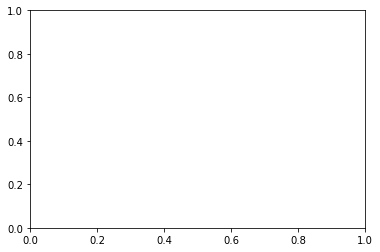

In [242]:
runXGBOOST(ntry)

[1642]	train-rmse:8.50246	valid-rmse:7.04845	train-r2:0.563524	valid-r2:0.646842
without klabels, with standardscaling

with klabels and standardscaling
[663]	train-rmse:6.94178	valid-rmse:5.37477	train-r2:0.709054	valid-r2:0.794647

In [236]:
import graphviz

In [237]:
plot_tree(clf)

NameError: name 'plot_tree' is not defined

In [254]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

AttributeError: 'Booster' object has no attribute 'evals_result'

In [ ]:
from sklearn.svm import SVR

In [153]:
def svm_test(data):
    scores = []        
    x1 = data.iloc[:,:-2]
    y1 = data['y']
    x_train, x_valid, y_train, y_valid = train_test_split(x1, y1, test_size=0.2, random_state=4242)
        
    svr=SVR(kernel = 'rbf', C=3) 
    svr.fit(x_train,y_train)
                
    scores.append(svr.score(x_valid, y_valid))
    
    plt.plot(x_valid, svr.predict(x_valid))
    plt.scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        facecolor="none",
        edgecolor="k",
        s=50,
        label="other training data",
    )
    return scores

In [154]:
scores = svm_test(emb_df)

In [155]:
print(scores)

[0.48060700813766055, 0.5090126242408544]


In [190]:
from sklearn.neighbors import KNeighborsRegressor

x_1 = label[1].iloc[:,:-3]
y_1 = label[1]['y']

x1_train, x1_valid, y1_train, y1_valid = train_test_split(x_1, y_1, test_size=0.2, random_state=4242)

neigh = KNeighborsRegressor(n_neighbors=15, weights='uniform')
neigh.fit(x1_train, y1_train)
neigh.score(x1_valid,y1_valid)

0.4083942942390716